In [1]:
#import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import matplotlib as mpl
import squarify as sq
sns.set_style('whitegrid')
sns.set_palette('Paired')

import missingno as msno
from icecream import ic
import time
import os
import re
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
from kaleido.scopes.plotly import PlotlyScope
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = 100

# plotly settings and functions
scope = PlotlyScope(plotlyjs="https://cdn.plot.ly/plotly-latest.min.js")
pio.templates.default = 'plotly_white'

# READING THE DATASET

In [2]:
survey=pd.read_csv('.\dataset\survey_dropped_columns.csv') 

In [3]:
survey.shape

(98855, 74)

In [4]:
survey.head()

,Age,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,AssessBenefits1,AssessBenefits10,AssessBenefits11,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessJob1,AssessJob10,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,CareerSatisfaction,CommunicationTools,CompanySize,ConvertedSalary,Country,Currency,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,Dependents,DevType,EducationTypes,Employment,FormalEducation,FrameworkDesireNextYear,FrameworkWorkedWith,Gender,HopeFiveYears,HoursComputer,IDE,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,JobSatisfaction,JobSearchStatus,LanguageDesireNextYear,LanguageWorkedWith,LastNewJob,Methodology,MilitaryUS,OpenSource,OperatingSystem,PlatformDesireNextYear,PlatformWorkedWith,RaceEthnicity,Respondent,SalaryType,SelfTaughtTypes,SexualOrientation,Student,UndergradMajor,UpdateCV,VersionControl,YearsCoding,YearsCodingProf
0,25 - 34 years old,Strongly agree,Strongly agree,Neither Agree nor Disagree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,7.0,8.0,1.0,2.0,5.0,3.0,4.0,9.0,Extremely satisfied,Slack,20 to 99 employees,NaN,Kenya,NaN,KES,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Yes,Full-stack developer,"Taught yourself a new language, framework, or ...",Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Django;React,Django;React,Male,Working as a founder or co-founder of my own c...,9 - 12 hours,Komodo;Vim;Visual Studio Code,5.0,6.0,7.0,2.0,1.0,4.0,3.0,Extremely satisfied,"I’m not actively looking, but I am open to new...",JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Less than a year ago,Agile;Scrum,NaN,No,Linux-based,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Black or of African descent,1,Monthly,The official documentation and/or standards fo...,Straight or heterosexual,No,Mathematics or statistics,My job status or other personal status changed,Git,3-5 years,3-5 years
1,35 - 44 years old,Agree,Agree,Neither Agree nor Disagree,1.0,2.0,8.0,5.0,3.0,7.0,10.0,4.0,11.0,9.0,6.0,1.0,9.0,7.0,10.0,8.0,2.0,5.0,4.0,3.0,6.0,Neither satisfied nor dissatisfied,Confluence;Office / productivity suite (Micros...,"10,000 or more employees",70841.0,United Kingdom,British pounds sterling (£),GBP,PostgreSQL,Redis;PostgreSQL;Memcached,Yes,Database administrator;DevOps specialist;Full-...,"Taught yourself a new language, framework, or ...",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",React,Django,Male,Working in a different or more specialized tec...,5 - 8 hours,IPython / Jupyter;Sublime Text;Vim,1.0,3.0,4.0,5.0,2.0,6.0,7.0,Moderately dissatisfied,I am actively looking for a job,Go;Python,JavaScript;Python;Bash/Shell,More than 4 years ago,NaN,NaN,Yes,Linux-based,Linux,Linux,White or of European descent,3,Yearly,The official documentation and/or standards fo...,Straight or heterosexual,No,"A natural science (ex. biology, chemistry, phy...",I saw an employer’s advertisement,Git;Subversion,30 or more years,18-20 years
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderately satisfied,NaN,20 to 99 employees,NaN,United States,NaN,NaN,NaN,NaN,NaN,Engineering manager;Full-stack developer,NaN,Employed full-time,Associate degree,NaN,NaN,NaN,Working as a founder or co-founder of my own c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderately satisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,Less than a year ago,NaN,NaN,Yes,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,24-26 years,6-8 years
3,35 - 44 years old,Disagree,Disagree,Strongly disagree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slightly dissatisfied,NaN,100 to 499 employees,NaN,United States,

# FINDING MISSING VALUES

In [5]:
def paste_px_format(figure, **kwargs):
 #Updates Layout of the Figure with custom setting
    return figure.update_layout(**kwargs,
        font={'color': 'Gray', 'size': 10},
        width=780, margin={'pad': 10})


def save_figure(fig, name):
    with open(name, "wb") as f:
        save = scope.transform(fig, format="png")
        f.close()
        
        
def add_bubble(fig, **kwargs):
#Creates shape ontop of the figure
    return fig.add_shape(
        type="circle",
        line_color="white", 
        fillcolor="orange",
        opacity=0.6,
        xref='paper', yref='paper',
        x0=0.5, y0=0.6)


def prepare_data_salary(df, col)-> pd.DataFrame:
   
   # Returns a cross tab of selected for col parameter as a pandas dataframe.

    df_concat = pd.concat(
        [df[col], survey['CompTotal']], axis=1)\
        .dropna()
    
    df_concat['salary_cat'] = pd.qcut(
        df_concat['CompTotal'], 5, labels=[
        "Low(<10,000)", "Low-Med(10k-49k)",
        "Medium(49k-85k)", "High(85k-150k)",
        "Very High(150<)"])
    
    crosstab = pd.crosstab(
        df_concat[col],
        df_concat['salary_cat'])
    
    return crosstab


def get_files():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            return (os.path.join(dirname, filename))

In [6]:
def missing_bar()-> go.Figure:
#Plots Missing Data for Whole Dataset
    title = 'Survey <b>Missing</b> Data by Features'
    
    # counts missing data
    missing_data = survey.isna().sum()
    missing_data = missing_data.to_frame().reset_index().rename(
        columns={'index': 'data_cols', 0: 'counts'})
    missing_data = missing_data.sort_values(by='counts', ascending=False)
    missing_perc = np.round(
        (survey.isna().sum().sum() / survey.size) * 100, 2)
    
    # figure colors
    colors = ['Gray'] * len(missing_data)
    colors[:10] = ['Orange']
    
    
    # create figure
    fig = go.Figure()
    for labels, values\
    in zip(missing_data.data_cols.to_list(), missing_data.counts):
    
        fig.add_trace(go.Bar(
            y=[labels],
            x=[values],
            name=labels,
            orientation='h'))
    
    # tweaking the layout
    fig.update_traces(marker_color=colors)
    fig.update_xaxes(title='Missing Counts')
    fig.update_yaxes(title='Features', tickmode='linear')
    
    fig.add_annotation(xref='paper', yref='paper',
        x=0.71, y=0.70, text=f"""
            {missing_perc}%""",
        font={'size': 20, 'color': 'White'},
        showarrow=False)
    
    fig.add_annotation(xref='paper', yref='paper',
        x=0.68, y=0.67, text=f"""Missing""",
        font={'size': 15, 'color': 'Gray'},
        showarrow=False)
    
    add_bubble(fig)

    return paste_px_format(
        fig, title=title, height=1000, showlegend=False)

In [8]:
#Displaying the missing values
missing_bar()

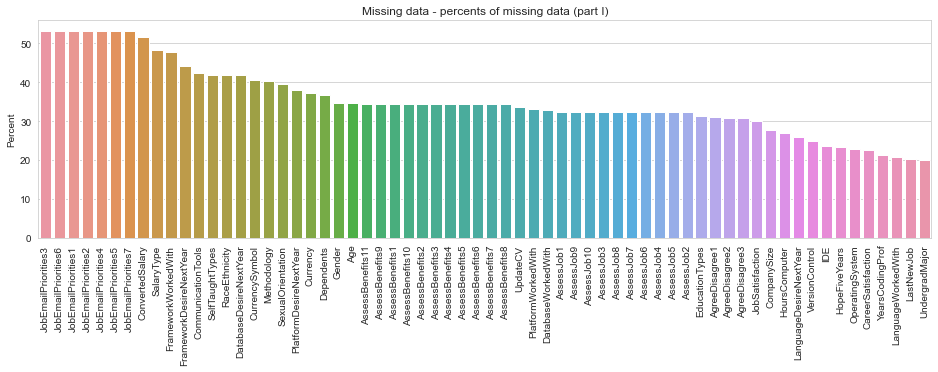

In [9]:
#converting to percentage
total = survey.isnull().sum().sort_values(ascending = False)
percent = (survey.isnull().sum()/survey.isnull().count()*100).sort_values(ascending = False)
tmp = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#plotting the data
def plot_missing_data(start, end, text):
    tmp1 = tmp[start:end]
    plt.figure(figsize = (16,4))
    plt.title('Missing data - percents of missing data (part %s)' % text)
    s = sns.barplot(x=tmp1.index,y=tmp1['Percent'])
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()    
    
#displaying the percentage of missing values
plot_missing_data(1,65,"I")


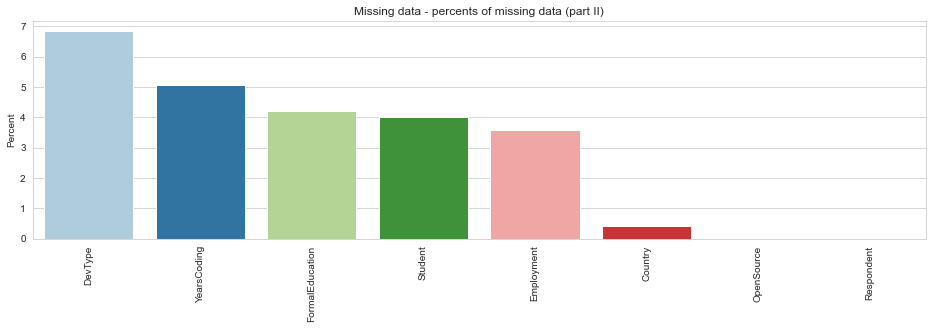

In [10]:
plot_missing_data(66,129,"II")

In [11]:
# sexuality values to dataframe
sexuality = survey['SexualOrientation'].value_counts().to_frame().T 

# wrangle data
sexuality_hetero = sexuality['Straight or heterosexual'].to_frame()
sexuality_lgbtq = sexuality.iloc[:, 2:]
sexuality_lgbtq = sexuality_lgbtq.sum(axis=1)\
    .to_frame()\
    .rename(columns={0: 'LGBTQ+'})

# prepare data for plot
sexuality = pd.concat([sexuality_hetero, sexuality_lgbtq], axis=1)

In [12]:
def plot_donut():
    
    # counts missing data
    missing_data = survey.isna().sum()
    missing_data = missing_data.to_frame().reset_index().rename(
        columns={'index': 'data_cols', 0: 'counts'})
    missing_data = missing_data.sort_values(by='counts', ascending=False)
    missing_perc = np.round(
        (survey.isna().sum().sum() / survey.size) * 100, 2)
    
    # figure colors
    colors = ['Gray'] * len(missing_data)
    colors[:10] = ['Orange']
    
    # figure colors
    labels = ['Heterosexual','LGBTQ+']
    
    # explosion
    explode = (0.05, 0.05)
    
    # Pie Chart
    plt.pie(sexuality.iloc[0,:], colors=colors, labels=labels,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
    
    # draw circle
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig = plt.gcf()

    # Adding Circle in Pie chart
    fig.gca().add_artist(centre_circle)

    # Adding Title of chart
    plt.title('Sexuality distribution for Survey')

    # Displaying Chart
    plt.show()

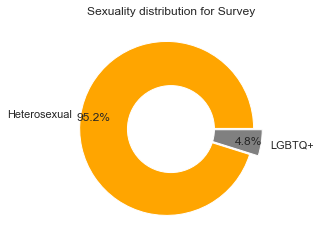

In [116]:
plot_donut()

## HELPER FUNCTIONS

In [13]:
#defining the functions
def plot_categorical_count(survey, column, title='', limit=2, xtick_rotation='horizontal'):
    column_count = survey[column].value_counts()[:limit]
    
    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x=column_count.index, y=column_count.values, palette='Paired')
    sns.despine(left=True)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=xtick_rotation)

    #plotting heatmap
def plot_heatmap(survey, variable):
    l = []
    for name, group in top10_df.groupby('Country'):
        dff = pd.DataFrame(group[variable].value_counts() / group[variable].count()) 
        dff['Country'] = name
        dff['rate'] = dff.index
        l.append(dff)
    fig = plt.figure(figsize=(14, 8))
    df_2 = pd.concat(l)
    dff = df_2.pivot_table(index='Country', columns='rate')
    sns.heatmap(dff, cmap="YlGnBu", linewidths=.3) 
  

## SALARY DISTRIBUTION

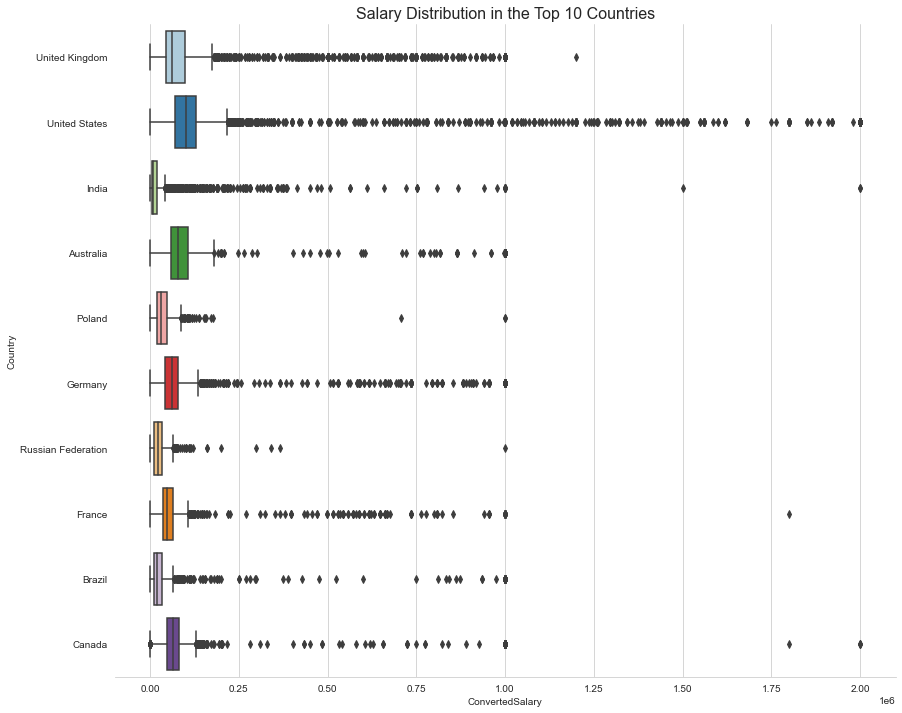

In [14]:
plt.figure(figsize=(14, 12))
top_10_list = list(survey['Country'].value_counts()[:10].index)


#limiting results to top 10 for clarifiation
df_top10 = survey.where(survey['Country'].isin(top_10_list))

#plotting the data
sns.boxplot(data=df_top10, x='ConvertedSalary', y='Country', palette='Paired')
plt.title('Salary Distribution in the Top 10 Countries', fontsize=16)
sns.despine(left=True)

# YEARS CODING PROFESSIONALLY W.R.T. COUNTRIES

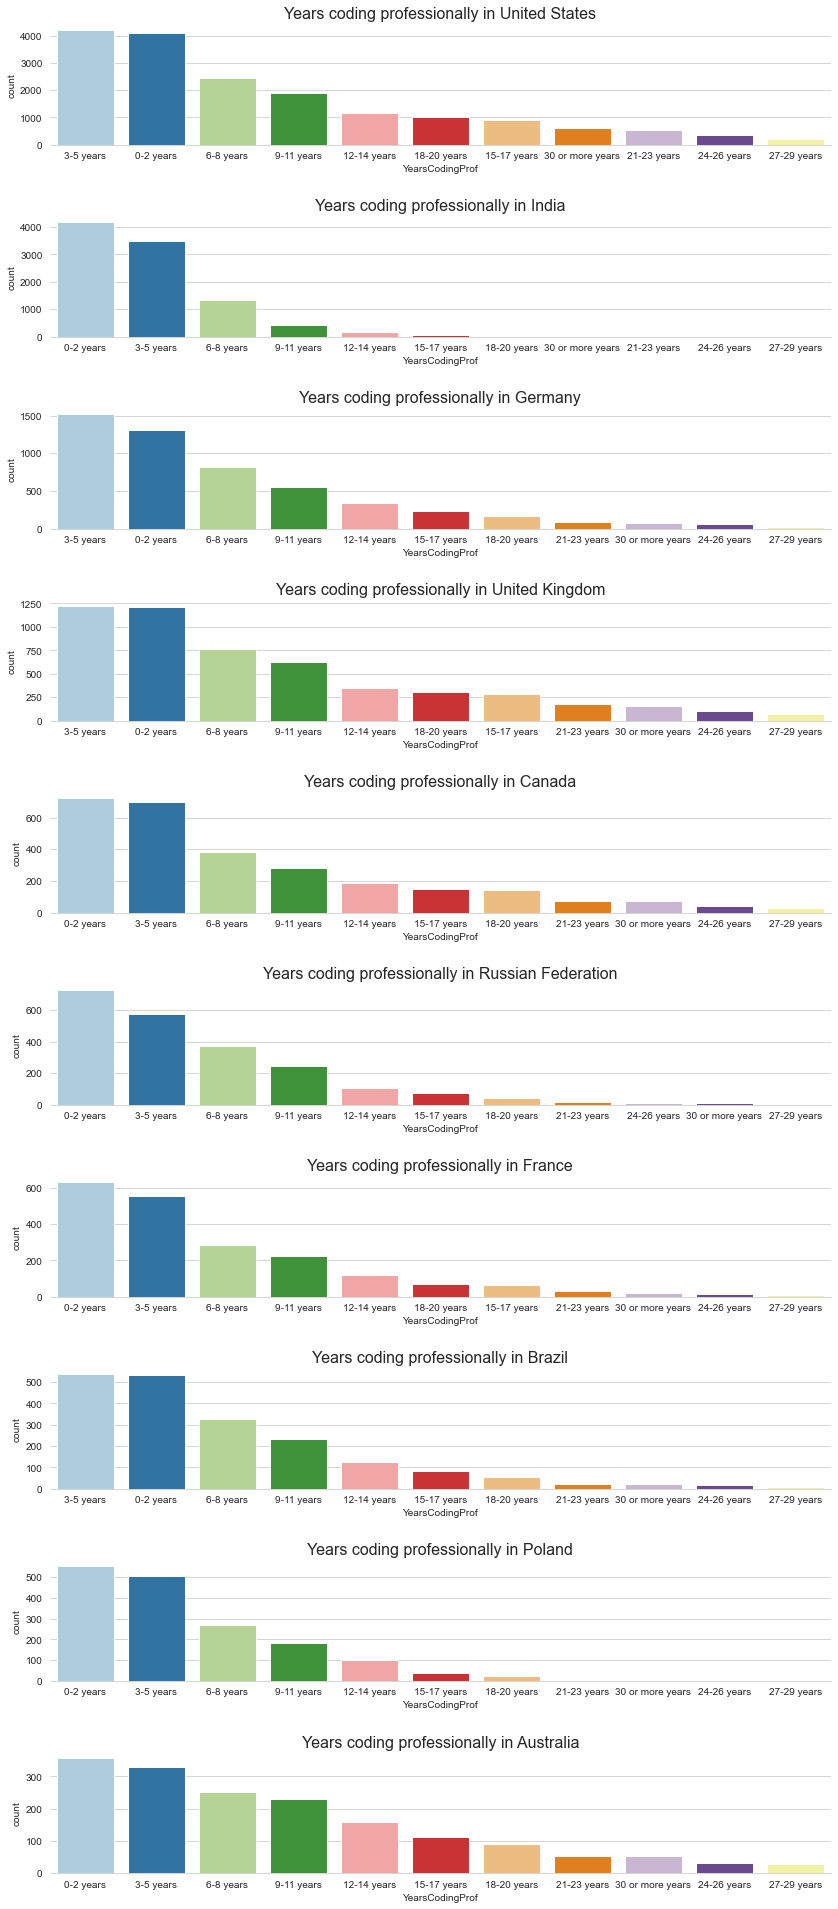

In [90]:
# Defining figure size
fig, axes = plt.subplots(10, 1, figsize=(14, 34))

for ax, country in zip(axes, top_10_list):
    data = survey[survey['Country'] == country]
    sns.countplot(data=data, x='YearsCodingProf', palette='Paired', ax=ax, order=data['YearsCodingProf'].value_counts().index)
    ax.set_title('Years coding professionally in {}'.format(country), fontsize=16)
    sns.despine(left=True)
    #
plt.subplots_adjust(hspace=.6)

# EMPLOYMENT STATUS OF DEVELOPERS

array([<AxesSubplot:ylabel='values'>], dtype=object)

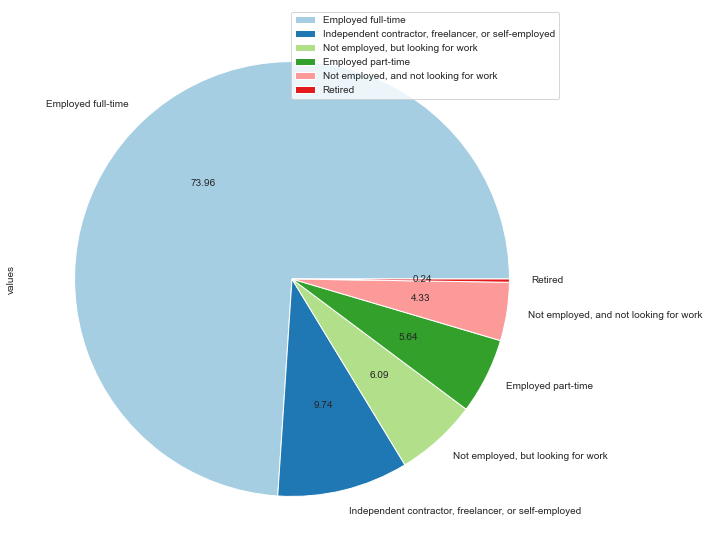

In [15]:
temp = survey.Employment.dropna().value_counts()
d = pd.DataFrame({'labels': temp.index,
                   'values': temp.values})
d = d.set_index('labels')
d.plot(kind='pie',autopct="%0.2f", figsize=(10,10), subplots=True)

# MAIN FIELD STUDY OF DEVELOPERS

<AxesSubplot:ylabel='UndergradMajor'>

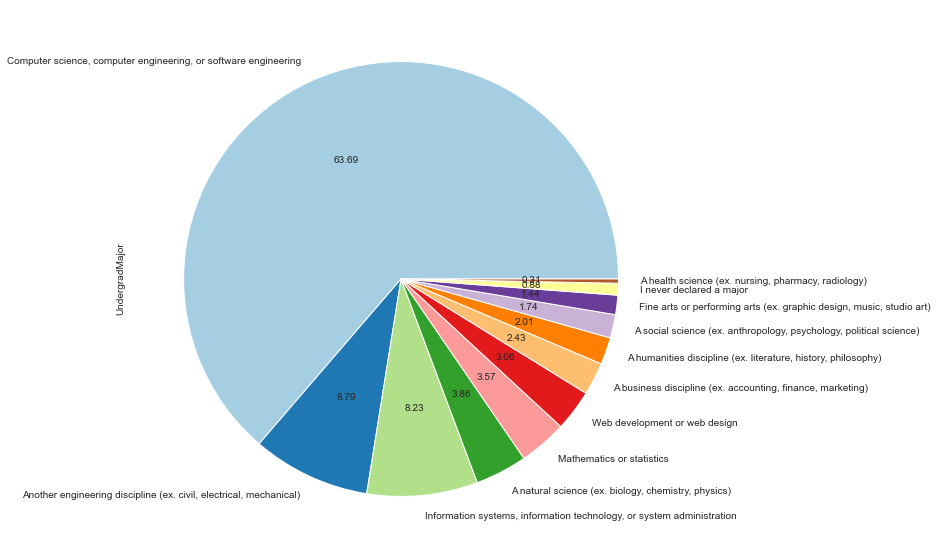

In [16]:
survey.UndergradMajor.dropna().value_counts().plot(kind='pie', autopct='%0.2f', figsize=(10,10))

## MOST REPRESENTED COUNTRIES

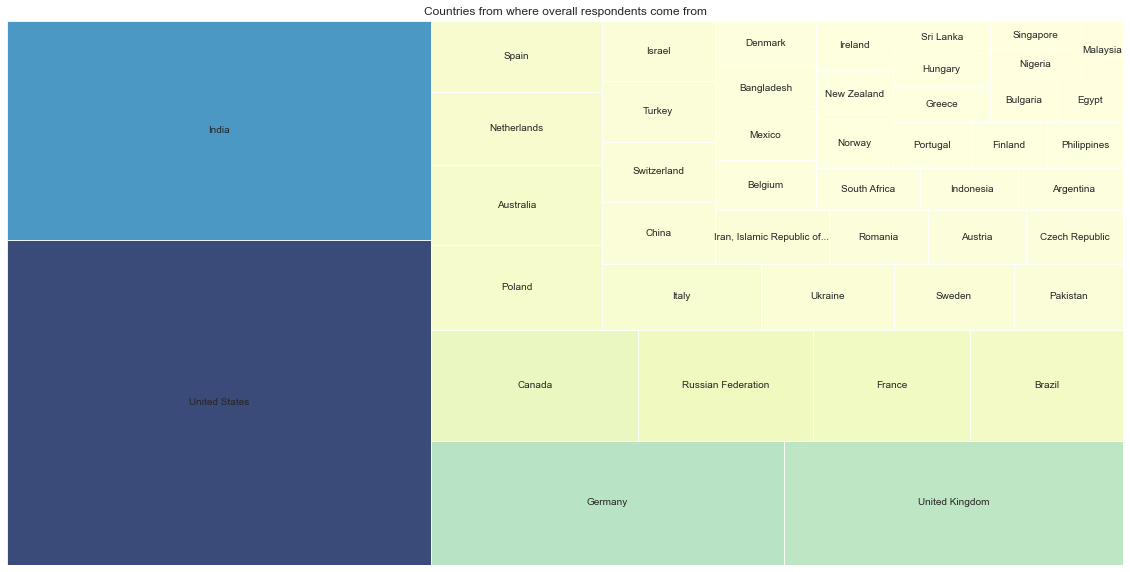

In [17]:
country = survey.groupby('Country').count()[['Respondent']].sort_values(by=['Respondent'], ascending=False).dropna().head(45)
# determining paramenters
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 10)
norm = mpl.colors.Normalize(vmin=min(country.Respondent), vmax=max(country.Respondent))
colors = [mpl.cm.YlGnBu(norm(value)) for value in country.Respondent]

# plotting the squareplot
sq.plot(label=country.index,sizes=country.Respondent,color = colors, alpha=.8)
plt.axis('off')
plt.title('Countries from where overall respondents come from')
plt.show()

### ANNUAL SALARY(USD) OVERALL DIST.

Text(0.5, 1.0, 'with Log')

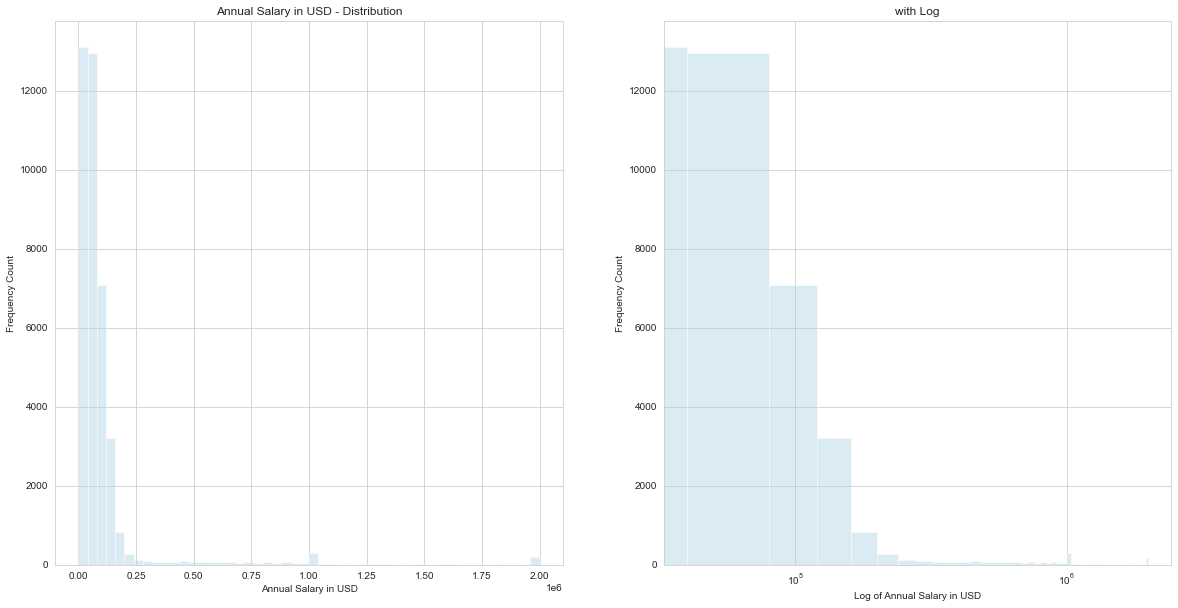

In [94]:
sal1 = survey[survey['Employment']=='Employed full-time']
sal1 = sal1.dropna(subset=['ConvertedSalary'])
fig,ax = plt.subplots(1,2, figsize=(20,10))

a = sns.distplot(sal1.ConvertedSalary, kde=False, ax=ax[0],axlabel = 'Annual Salary in USD')
a.set_ylabel('Frequency Count')
a.set_title('Annual Salary in USD - Distribution')
b = sns.distplot(sal1.ConvertedSalary,kde=False, ax=ax[1], axlabel = 'Log of Annual Salary in USD')
b.set_xscale('log')
b.set_ylabel('Frequency Count')
b.set_title('with Log')

### ANNUAL SALARY DIST. BY COUNTRY

In [95]:
countries_salary = survey[survey['Employment']=='Employed full-time']
countries_salary['count'] = countries_salary.groupby('Country')['Respondent'].transform('count')
countries_salary = countries_salary[countries_salary['count']>500]

Text(0.5, 1.0, 'Annual Salary in USD - Distribution by Country - More than 500 respondents')

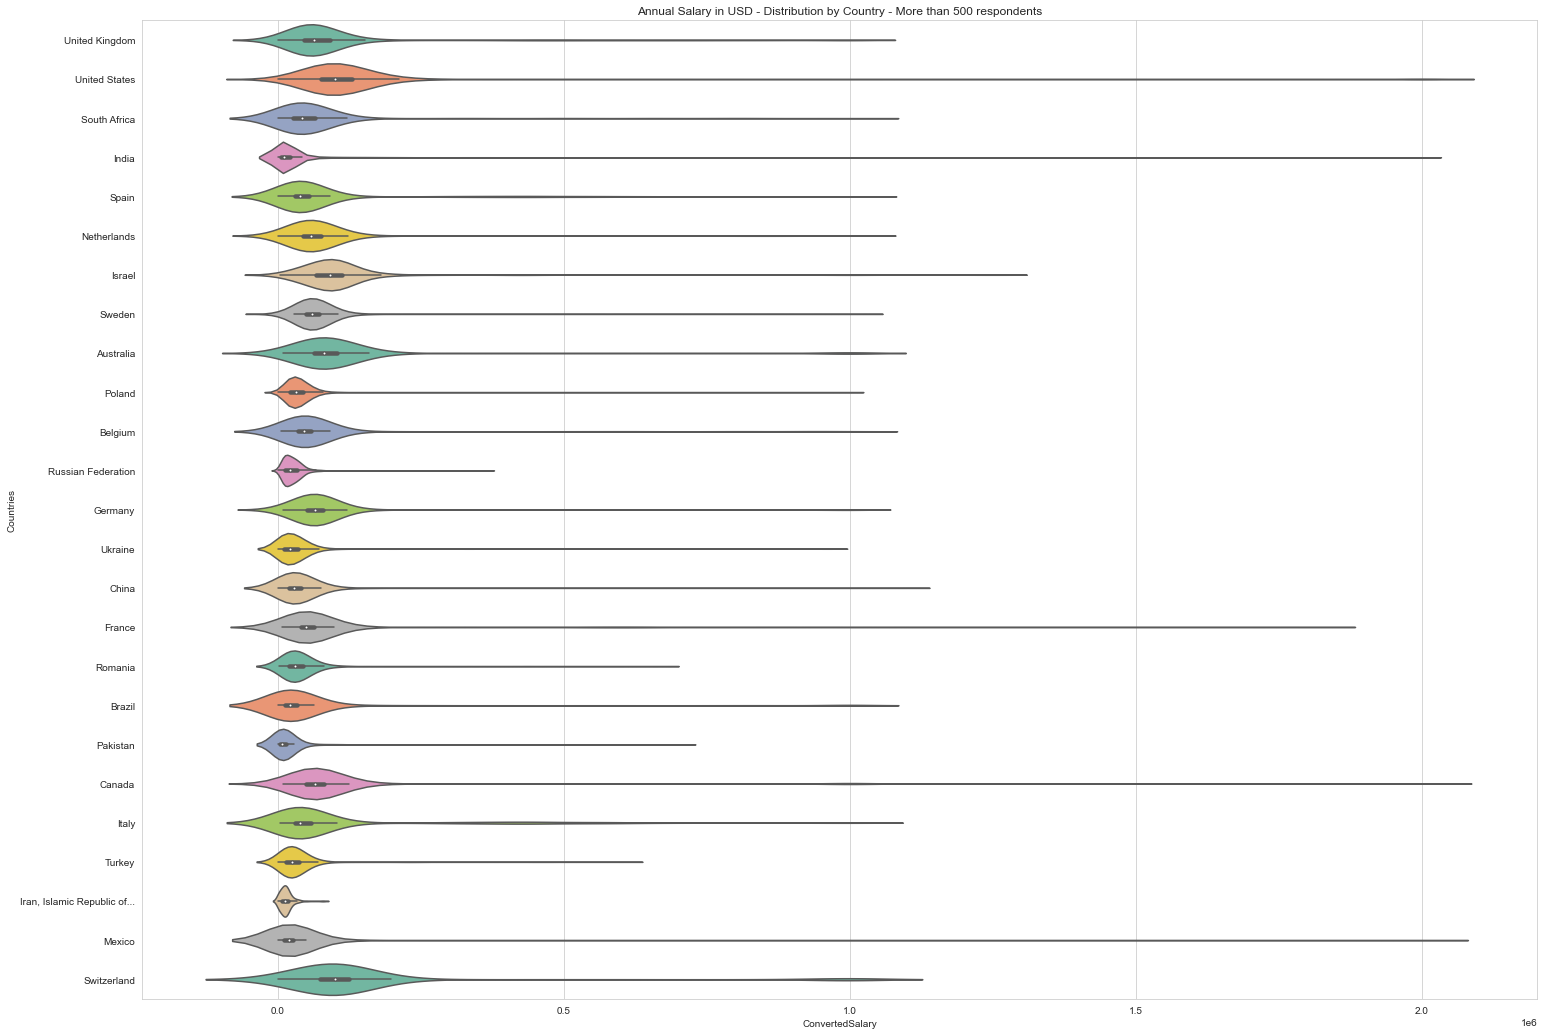

In [96]:
fig, ax =  plt.subplots(figsize=(25,18))
ax =sns.violinplot(x=countries_salary.ConvertedSalary, y=countries_salary.Country, data = countries_salary, scale="width", palette="Set2")
ax.set_ylabel('Countries')
ax.set_title('Annual Salary in USD - Distribution by Country - More than 500 respondents')

### IDE PREFERENCE

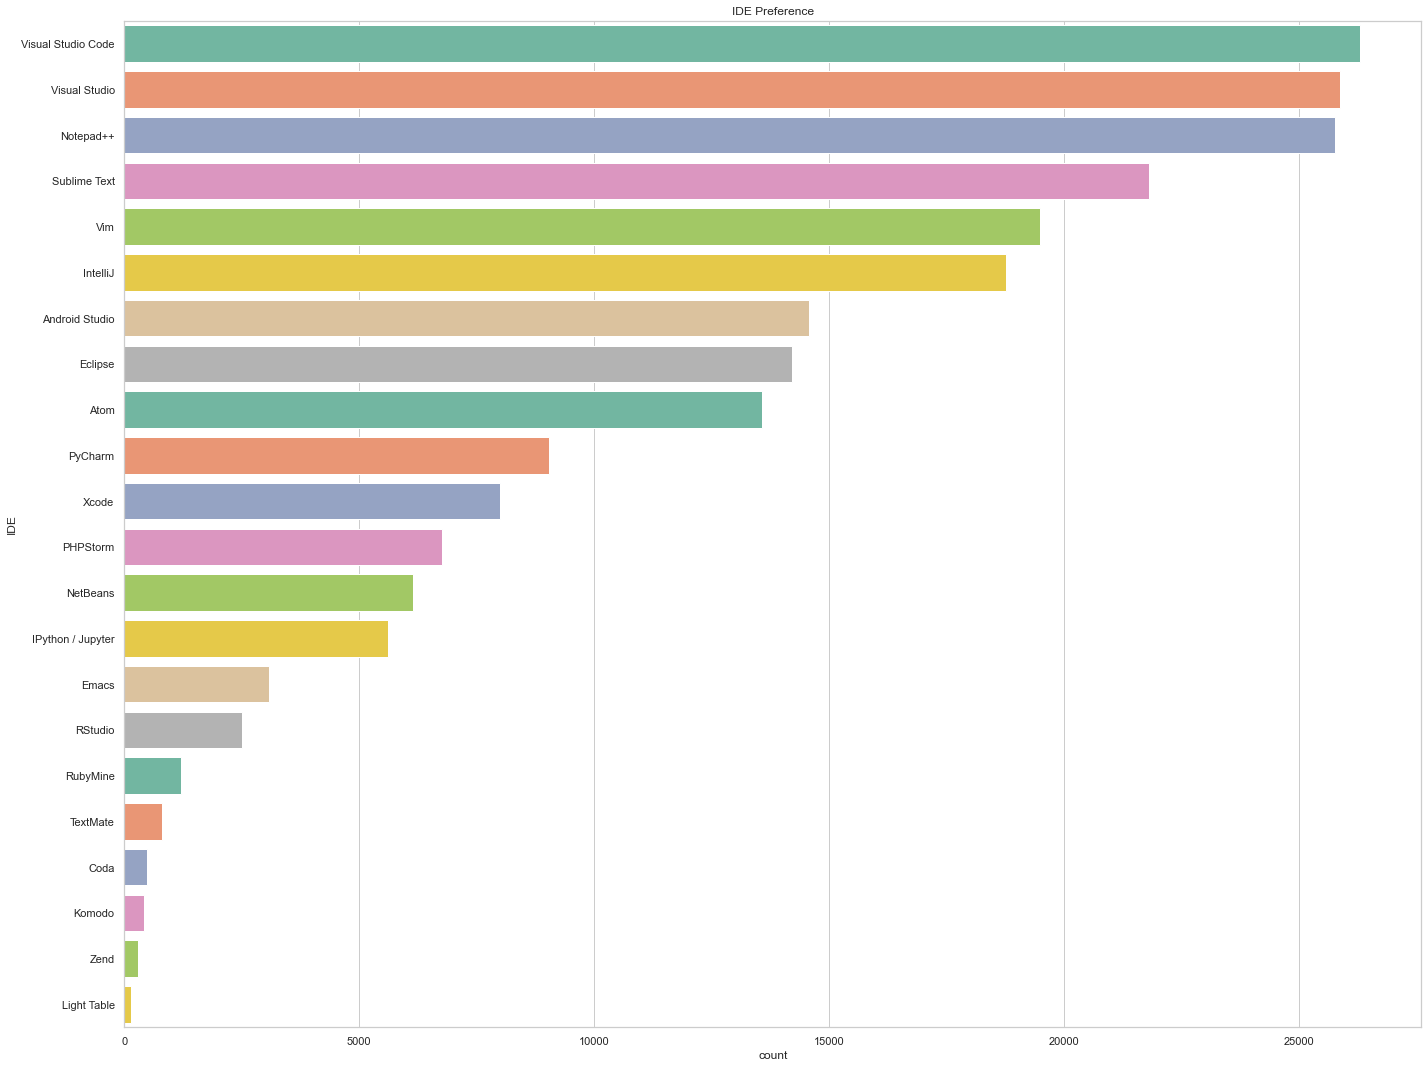

In [19]:
ide = survey[['IDE']]

#different kinds of IDEs
i = ide['IDE'].str.split(';').apply(pd.Series, 1).stack()
i.index = i.index.droplevel(-1) 
i.name = 'NewIDE'
ide = ide.join(i)

#plotting of IDE preferences
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.countplot(y="NewIDE", data=ide, order = ide['NewIDE'].value_counts().index ,palette="Set2" )
plt.ylabel('IDE')
plt.title('IDE Preference')
plt.tight_layout()

By Gender

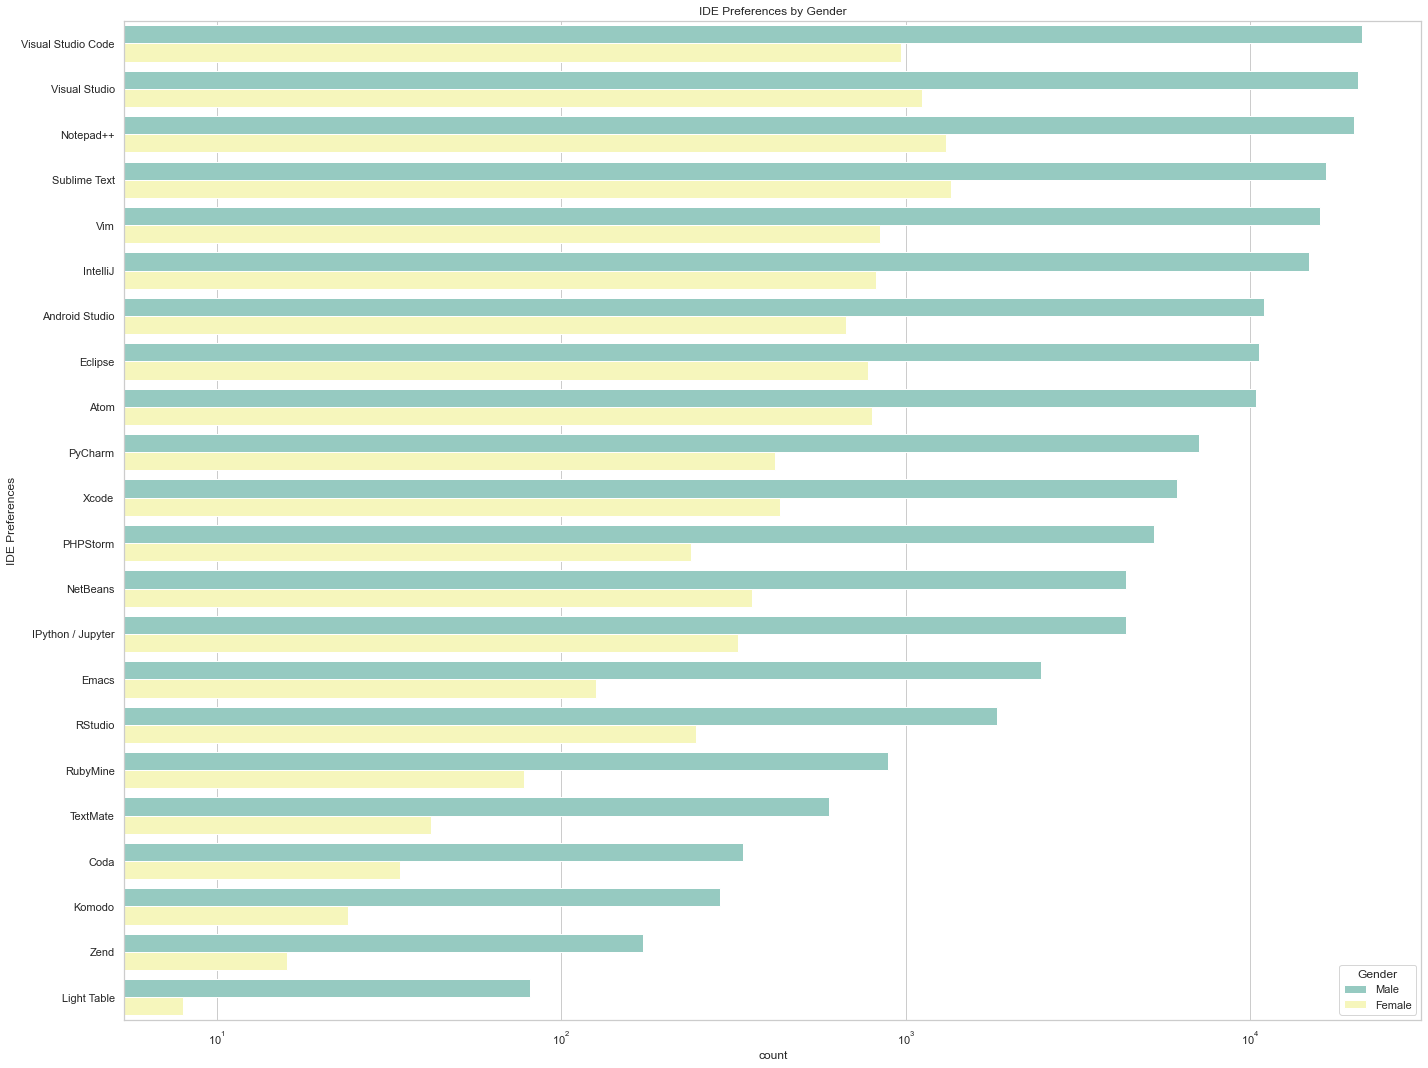

In [21]:
#gender bifurcation
ide_gen = survey.filter(items=['IDE', 'Gender'])
ide_gen = ide_gen.dropna(subset=['IDE'])
ide_gen = ide_gen[(ide_gen['Gender'] == 'Female') | (ide_gen['Gender']=='Male')]


i = ide_gen['IDE'].str.split(';').apply(pd.Series, 1).stack()
i.index = i.index.droplevel(-1) 
i.name = 'IDE_NEW'
ide_gen = ide_gen.join(i)

#plotting wrt bifurcation
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.countplot(y="IDE_NEW", hue="Gender", data=ide_gen, order = ide_gen['IDE_NEW'].value_counts().index ,palette="Set3" )
plt.xscale("log")
plt.ylabel('IDE Preferences')
plt.title('IDE Preferences by Gender')
plt.tight_layout() 

### LANGUAGES USED FOR EXTENSIVE DEVELOPMENT WORK

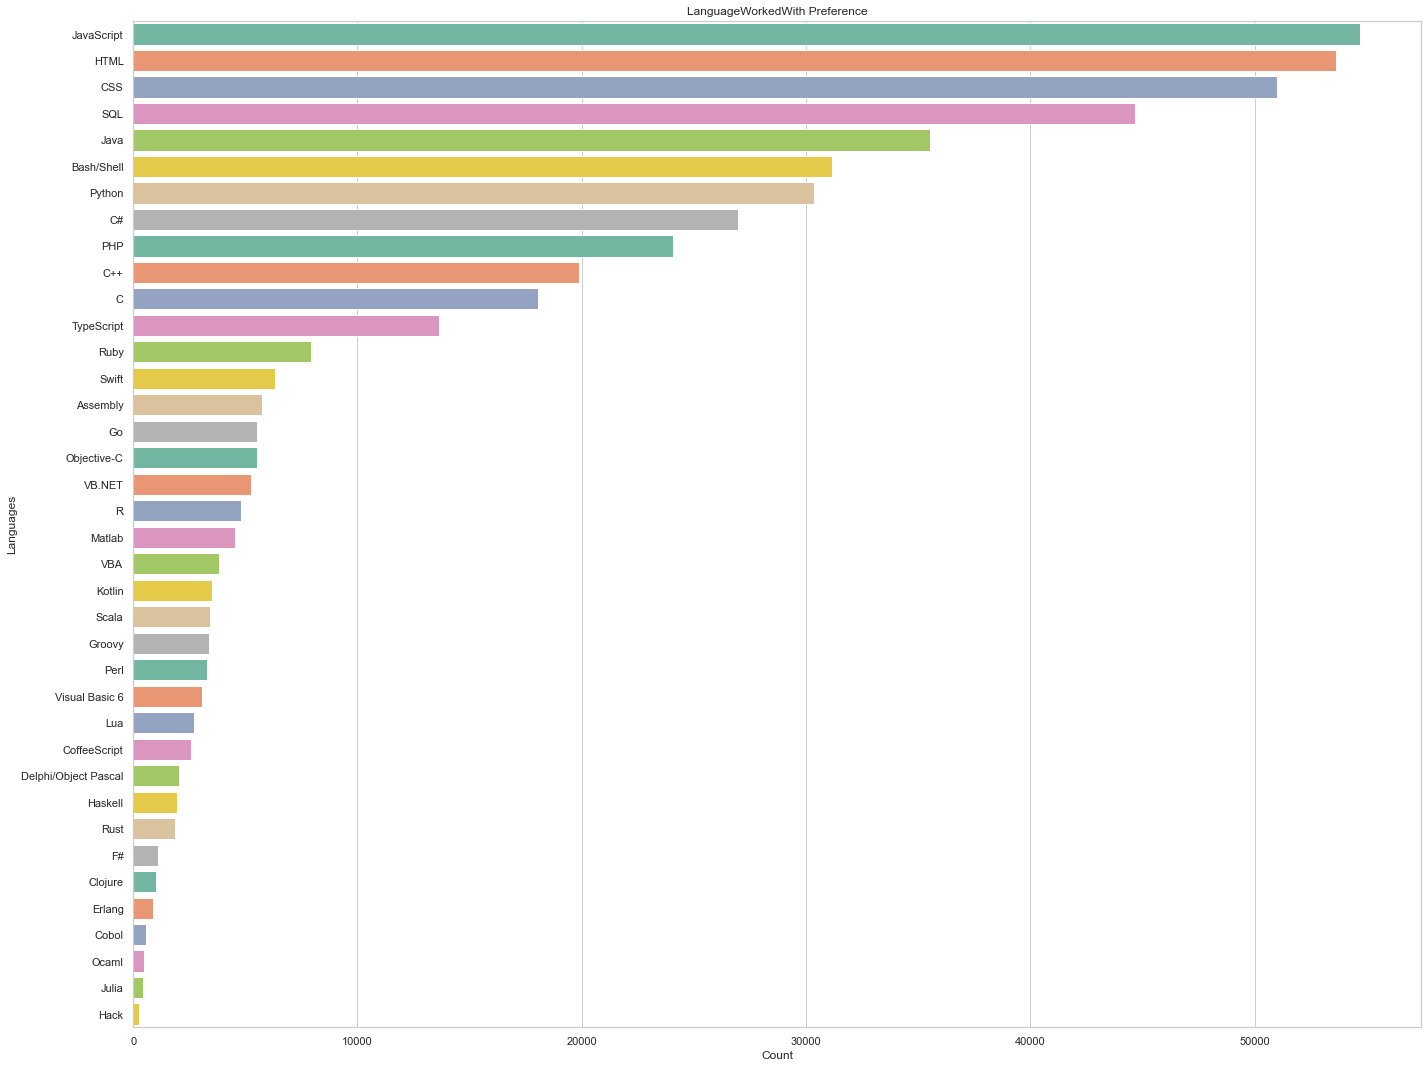

In [20]:
lang = survey[['LanguageWorkedWith']]
lang = lang.dropna(subset=['LanguageWorkedWith'])

#generating different kinds of languages worked with
l= lang['LanguageWorkedWith'].str.split(';').apply(pd.Series, 1).stack()
l.index = l.index.droplevel(-1) 
l.name = 'NewLang'
lang = lang.join(l)

#plotting wrt languages preference
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.countplot(y="NewLang", data=lang, order = lang['NewLang'].value_counts().index ,palette="Set2" )
plt.ylabel('Languages')
plt.xlabel('Count')
plt.title('LanguageWorkedWith Preference')
plt.tight_layout()

### FRAMEWORK WORKED WITH

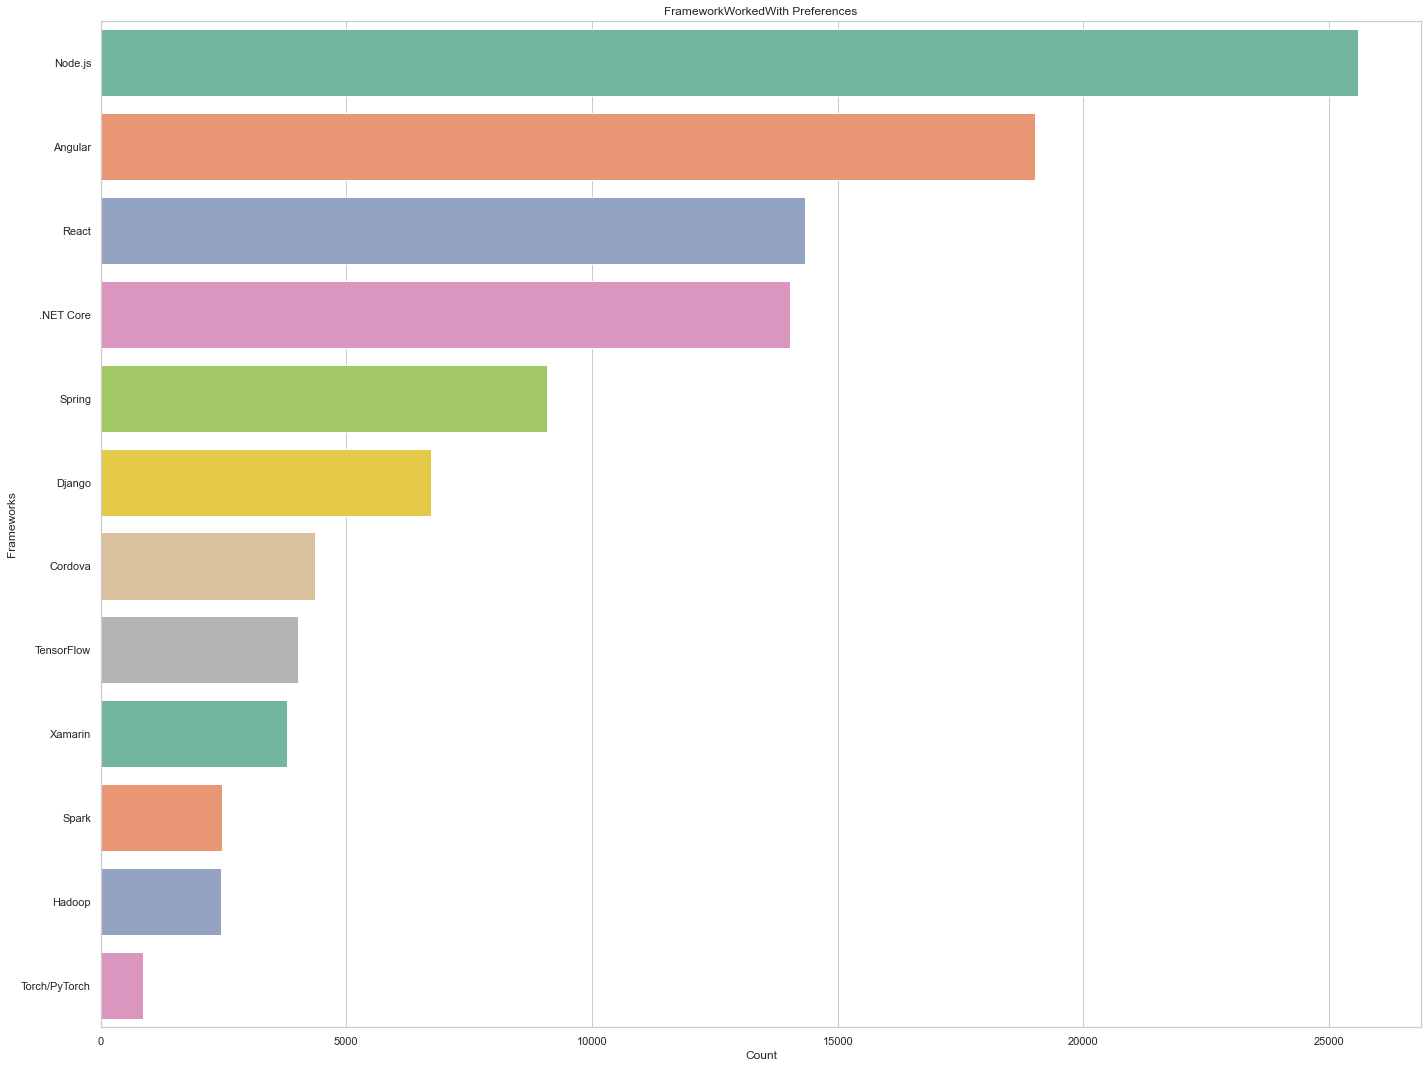

In [22]:
framework = survey[['FrameworkWorkedWith']]
framework = framework.dropna(subset=['FrameworkWorkedWith'])

# Determining the frameworks worked with
f= framework['FrameworkWorkedWith'].str.split(';').apply(pd.Series, 1).stack()
f.index = f.index.droplevel(-1) 
f.name = 'NewFrameworkWorkedWith'
framework = framework.join(f)

#plotting wrt frameworks preference
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.countplot(y="NewFrameworkWorkedWith", data=framework, order = framework['NewFrameworkWorkedWith'].value_counts().index ,palette="Set2" )
plt.ylabel('Frameworks')
plt.xlabel('Count')
plt.title('FrameworkWorkedWith Preferences')
plt.tight_layout()


By Gender

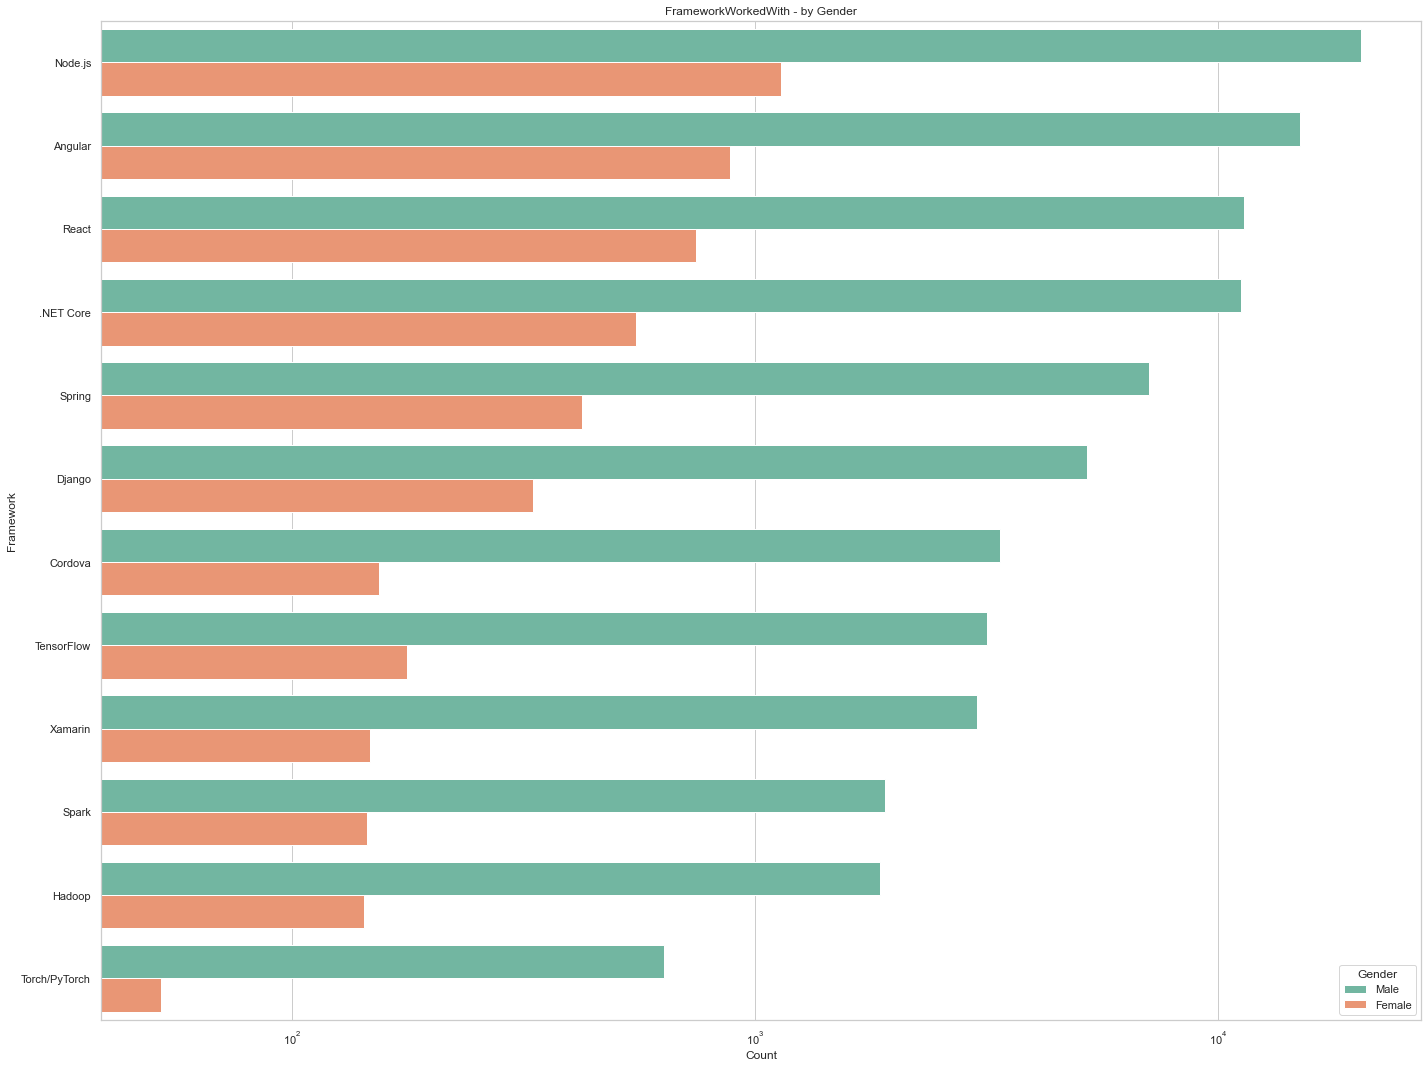

In [23]:
#gender bifurcatiom
framework_gen = survey.filter(items=['FrameworkWorkedWith', 'Gender'])
framework_gen = framework_gen.dropna(subset=['FrameworkWorkedWith'])
framework_gen = framework_gen[(framework_gen['Gender'] == 'Female') | (framework_gen['Gender']=='Male')]

f= framework_gen['FrameworkWorkedWith'].str.split(';').apply(pd.Series, 1).stack()
f.index = f.index.droplevel(-1) 
f.name = 'NewFramework'
framework_gen = framework_gen.join(f)

# plotting wrt bifuraction
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.countplot(y="NewFramework", hue="Gender", data=framework_gen, order = framework_gen['NewFramework'].value_counts().index ,palette="Set2" )
plt.xscale("log")
plt.ylabel('Framework')
plt.xlabel('Count')
plt.title('FrameworkWorkedWith - by Gender')
plt.tight_layout()